### This Python 3 notebook extracts images of a Gallica document (using the IIIF protocol), and then applies object detection to the images
1. Extract the document technical image metadata from its IIIF manifest,
2. Load the IIIF images,
3. Apply a yolo model.


In [11]:
import sys
import cv2
import os, fnmatch
from collections import namedtuple
import csv
import time

# insert here the Gallica document ID you want to process
docID = '12148/bpt6k46000341' # quotidien
#docID = '12148/btv1b6931954n' # photo
#docID = '12148/btv1b10336854c' # album
#docID = '12148/btv1b10544068q' # estampe
#docID = '12148/bpt6k65414058' # Vogue magazine

# IIIF export factor (%)
doc_export_factor = 10
# get docMax first images from the document
doc_max = 4
# data export
output = "OUT_csv"
output_img = "OUT_img"

# minimum confidence score to keep the detections
min_confidence = 0.20
# threshold when applying non-maxima suppression
threshold = 0.30

print("Python version")
print (sys.version)

Python version
3.8.7 (v3.8.7:6503f05dd5, Dec 21 2020, 12:45:15) 
[Clang 6.0 (clang-600.0.57)]


In [12]:
########## CSV output #############
output_dir = os.path.realpath(output)
if not os.path.isdir(output_dir):
	print(f"\n  Creating .csv directory {output}...")
	os.mkdir(output_dir);

print (f"\n... CSV files will be saved to {output}")

########## Images output #############
output_img_dir = os.path.realpath(output_img)
if not os.path.isdir(output_img_dir):
	print(f"\n  Creating img directory {output_img}...")
	os.mkdir(output_img_dir);

print (f"\n... images files will be saved to {output_img}\n")


... CSV files will be saved to OUT_csv

... images files will be saved to OUT_img



### 1. We first build the IIIF manifest URL and call the API

In [13]:
import requests

METADATA_BASEURL = 'https://gallica.bnf.fr/iiif/ark:/'
req_url = "".join([METADATA_BASEURL, docID, '/manifest.json'])
print ("... getting the IIIF manifest",req_url)
# we ask for the IIIF manifest. The call returns a dictionary
r = requests.get(req_url)
r.raise_for_status()
json_4img = r.json()
print (json_4img.keys())


... getting the IIIF manifest https://gallica.bnf.fr/iiif/ark:/12148/bpt6k46000341/manifest.json
dict_keys(['@id', 'label', 'attribution', 'license', 'logo', 'related', 'seeAlso', 'description', 'metadata', 'sequences', 'thumbnail', '@type', '@context'])


### 2. Now we load the images files thanks to the IIIF API Image protocol

In [14]:
from iiif_api import IIIF #  get the image files with the IIIF Image API (PyGallica package again)

# get the sequence of images metadata. It's a list
sequences = json_4img.get('sequences')
# get the canvases, first element of the list. Its a dict
canvases = sequences[0]
print (canvases.keys())
# get the sequence of images metadata. It's a list
sequences = json_4img.get('sequences')
# get the canvases, first element of the list. Its a dict
canvases = sequences[0]
print (canvases.keys())

# parse each canvas data for each image
# each canvas has these keys: [u'height', u'width', u'@type', u'images', u'label', u'@id', u'thumbnail']
n_images = 0
urlsIIIF = []
print ("... getting image metadata from the IIIF manifest")
for c in canvases.get('canvases'):
    n_images += 1
    print (" label:",c.get('label')," width:",c.get('width'), " height:",c.get('height'))
    # we also get a Gallica thumbnail (it's not a IIIF image)
    thumbnail = c.get('thumbnail')
    urlThumbnail = thumbnail.get('@id')
    #print " thumbnail: ",urlThumbnail
    # we build the IIIF URL. We ask for the full image with a size factor of docExportFactor
    urlIIIF = "".join([docID,'/f',str(n_images)]), 'full', "".join(['pct:',str(doc_export_factor)]), '0', 'native', 'jpg'
    urlsIIIF.append(urlIIIF)
    if n_images >= doc_max:
        break

print ("--------------")
print (f"... we get {doc_max} images on {len(canvases.get('canvases'))}\n")
print ("... now downloading the images")
[IIIF.iiif(u[0],u[1],u[2],u[3],u[4],u[5]) for u in urlsIIIF]

dict_keys(['canvases', 'label', '@type', '@id'])
dict_keys(['canvases', 'label', '@type', '@id'])
... getting image metadata from the IIIF manifest
 label: NP  width: 6287  height: 8677
 label: 2  width: 6314  height: 8650
 label: 3  width: 6287  height: 8677
 label: 4  width: 6314  height: 8650
--------------
... we get 4 images on 12

... now downloading the images
https://gallica.bnf.fr/iiif/ark:/12148/bpt6k46000341/f1/full/pct:10/0/native.jpg
https://gallica.bnf.fr/iiif/ark:/12148/bpt6k46000341/f2/full/pct:10/0/native.jpg
https://gallica.bnf.fr/iiif/ark:/12148/bpt6k46000341/f3/full/pct:10/0/native.jpg
https://gallica.bnf.fr/iiif/ark:/12148/bpt6k46000341/f4/full/pct:10/0/native.jpg


[None, None, None, None]

### 3. We display the images

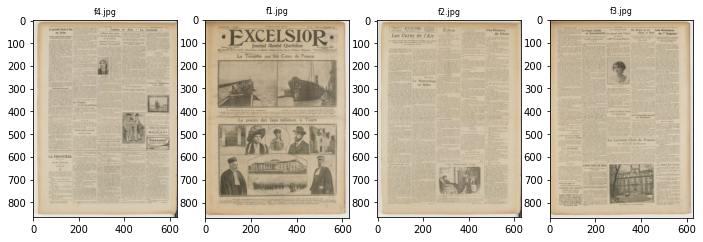

In [28]:
import io
from PIL import Image # pip install pillow
from PIL.Image import Image as PilImage
import matplotlib.pyplot as plt
import textwrap

def path_to_pil(folder,file):
    fileName = "".join([folder,"/",file]) # the images have been stored in a folder based on the document ID like 12148/btv1b103365619
    #print "--- loading image ",fileName,"..."
    img = Image.open(fileName)
    return img

# display images in a table
def display_images(
    images,
    columns=6, width=18, height=8, max_images=20,
    label_wrap_length=20, label_font_size=8):

    if len(images) == 1:
        display(images[0])
        return
    if not images:
        print ("No images to display!")
        return

    if len(images) > max_images:
        print ("Showing", max_images, " images of", len(images))
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size);

# first we read the images on disk
image_paths = fnmatch.filter(os.listdir(docID), '*.jpg')
images = [path_to_pil(docID,e) for e in image_paths]
display_images(images)


### 3. Now we process the images for objects detection using a Yolo model

In [29]:
import numpy as np
from imutils import paths

nb_objects = 0


def process_image(image,file_ID):
	# load our input image and grab its spatial dimensions
	file_name=image.filename
	print ("\n...analysing %s" % file_name)
	try:
		image = cv2.imread(file_name)
		(H, W) = image.shape[:2]
	except ValueError:
		print("Unexpected error:", sys.exc_info()[0])
		return

	global nb_objects
	outText=""

	# determine only the *output* layer names that we need from YOLO
	ln = net.getLayerNames()
	ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

	# construct a blob from the input image and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes and
	# associated probabilities
	blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416,416), swapRB=True, crop=False)
	net.setInput(blob)
	start = time.time()
	layerOutputs = net.forward(ln)
	end = time.time()

	# show timing information on YOLO
	#print(" YOLO took {:.6f} seconds".format(end - start))

	# initialize our lists of detected bounding boxes, confidences, and
	# class IDs, respectively
	boxes = []
	confidences = []
	classIDs = []

	# loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability) of
			# the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
			if confidence > min_confidence:
				# scale the bounding box coordinates back relative to the
				# size of the image, keeping in mind that YOLO actually
				# returns the center (x, y)-coordinates of the bounding
				# box followed by the boxes' width and height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# use the center (x, y)-coordinates to derive the top and
				# and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# update our list of bounding box coordinates, confidences,
				# and class IDs
				boxes.append([x, y, int(width), int(height)])
				confidences.append(float(confidence))
				classIDs.append(classID)

	# apply non-maxima suppression to suppress weak, overlapping bounding boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, threshold)

	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			nb_objects += 1
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])

			# build the CSV data
			if (outText ==""):
				outText = "%s,%d,%d,%d,%d,%.2f" % (LABELS[classIDs[i]], x, y, w, h, confidences[i])
			else:
				outText = "%s_%s,%d,%d,%d,%d,%.2f" % (outText, LABELS[classIDs[i]], x, y, w, h, confidences[i])
			# draw a bounding box rectangle and label on the image
			color = [int(c) for c in COLORS[classIDs[i]]]
			cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
			cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
			#imS = cv2.resize(image, None,fx=0.3, fy=0.3, interpolation = cv2.INTER_CUBIC)
			# show the output image
			#cv2.imshow("Image", imS)
			#cv2.waitKey(0)
			print (text)

		if outText != "":
			# open output file
			out_CSV_file = os.path.join(output_dir, docID, "%s.csv" % file_ID)
			out_CSV_path = os.path.join(output_dir, docID)
			if not(os.path.exists(out_CSV_path)):
				os.makedirs(out_CSV_path);
			out = open(out_CSV_file,"w")
			print ("%s;%s" % (file_name, outText), file=out) # separator = ;
			out.close()
			# show the output image
			#cv2.imshow("Output", image)
			#cv2.waitKey(0)
			# save image
			out_img_path = os.path.join(output_img_dir, f"{file_ID}.jpg" )
			print ("...writing annotated image:", f"{file_ID}.jpg")
			cv2.imwrite(out_img_path, image)
		else:
			print ("\tno detection")
            

In [19]:
print("... loading the model")
labelsPath = os.path.sep.join(["yolo_v4", "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join(["yolo_v4", "yolov4.weights"])
configPath = os.path.sep.join(["yolo_v4", "yolov4.cfg"])

# load our YOLO object detector trained on COCO dataset (80 classes)
print("... loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

print ("... now infering")
for i in image_paths:
	file_ID = os.path.splitext(os.path.basename(i))[0]
	image = path_to_pil(i)
	try:
		process_image(image,file_ID)
	except AttributeError as exc:
		print("Unexpected error:", exc)

print (f"\n ### objects detected: {nb_objects} ###")
print (f" ### images analysed: {len(image_paths)} ###")
print ("---------------------------")

... loading the model
... loading YOLO from disk...
... now infering

...analysing 12148/bpt6k46000341/f4.jpg
person: 0.5486
book: 0.3244
person: 0.2982
...writing annotated image: f4.jpg

...analysing 12148/bpt6k46000341/f1.jpg
person: 0.8593
person: 0.5928
person: 0.4781
person: 0.3570
tie: 0.3399
person: 0.3364
horse: 0.3086
refrigerator: 0.2286
...writing annotated image: f1.jpg

...analysing 12148/bpt6k46000341/f2.jpg
book: 0.8542
...writing annotated image: f2.jpg

...analysing 12148/bpt6k46000341/f3.jpg
book: 0.8242
person: 0.4836
...writing annotated image: f3.jpg

 ### objects detected: 14 ###
 ### images analysed: 4 ###
---------------------------


OUT_img/f4.jpg


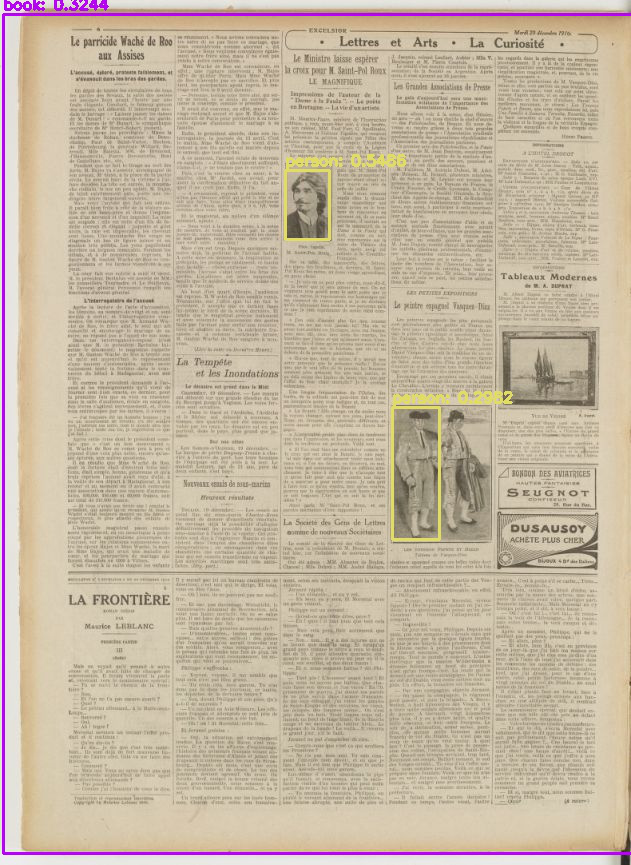

OUT_img/f1.jpg


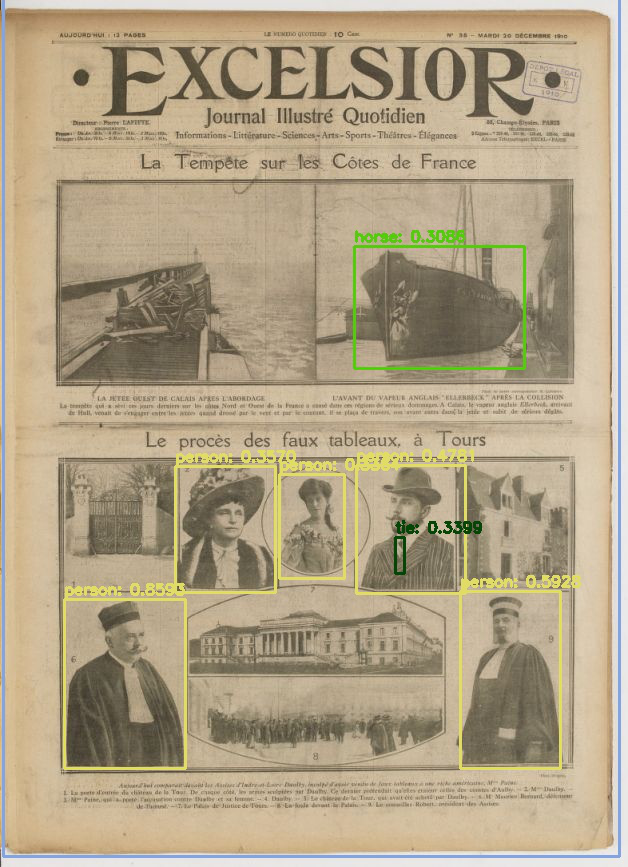

OUT_img/f2.jpg


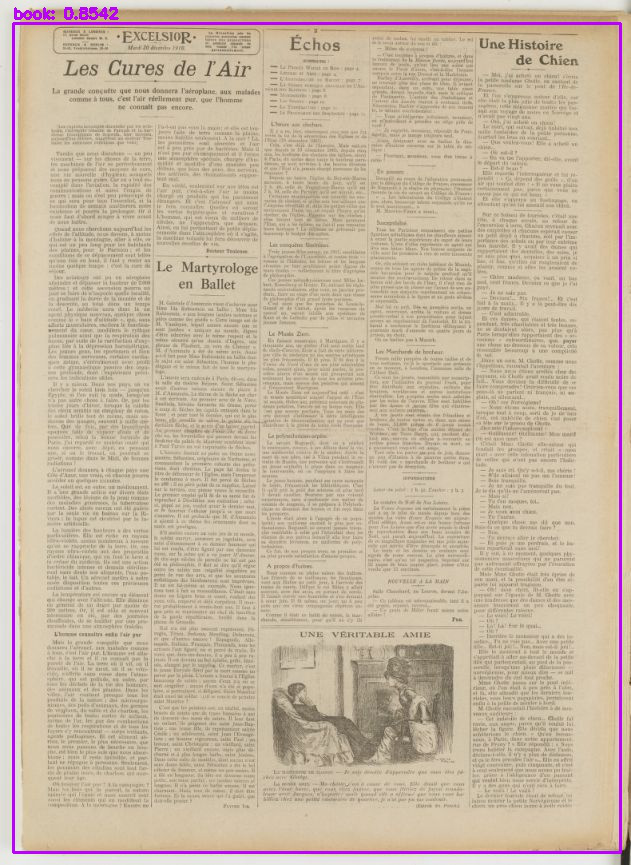

OUT_img/f3.jpg


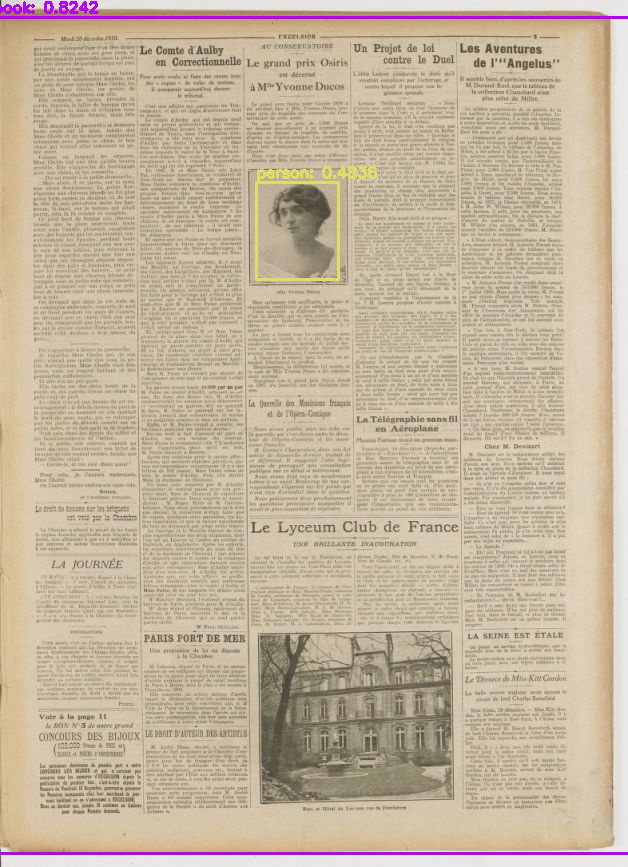

In [31]:
out_paths = fnmatch.filter(os.listdir(output_img), '*.jpg')
annotated_images = [path_to_pil(output_img,e) for e in out_paths]
for im in annotated_images:
    print (im.filename)
    display(im)